In [1]:
import pandas as pd

# Load the dataset
train_path = r"C:\Users\90552\Downloads\archive (1)\DailyDelhiClimateTrain.csv"
test_path = r"C:\Users\90552\Downloads\archive (1)\DailyDelhiClimateTest.csv"

# Load the CSV file
df1 = pd.read_csv(train_path)
df2 = pd.read_csv(test_path)
data = pd.concat([df1, df2], ignore_index=True)
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [2]:
df = data.set_index('date')[['meantemp']]

In [3]:
df.head()

,meantemp
date,
2013-01-01,10.000000
2013-01-02,7.400000
2013-01-03,7.166667
2013-01-04,8.666667
2013-01-05,6.000000


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.8
validate_size = 0.1
test_size = 0.1

train_data, temp_data = train_test_split(df, train_size=train_size, shuffle=False)
validate_data, test_data = train_test_split(temp_data, test_size=test_size / (validate_size + test_size), shuffle=False)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data only and transform the splits
train_data['meantemp'] = scaler.fit_transform(train_data[['meantemp']])
validate_data['meantemp'] = scaler.transform(validate_data[['meantemp']])
test_data['meantemp'] = scaler.transform(test_data[['meantemp']])

# Output the sizes of the splits
print(f"Train size: {train_data.shape}")
print(f"Validate size: {validate_data.shape}")
print(f"Test size: {test_data.shape}")

# Display the training data
print(train_data.head())

Train size: (1260, 1)
Validate size: (158, 1)
Test size: (158, 1)
            meantemp
date                
2013-01-01 -2.014442
2013-01-02 -2.360247
2013-01-03 -2.391281
2013-01-04 -2.191778
2013-01-05 -2.546450


In [5]:
import numpy as np

def create_sequences(data, sequence_length):
    """
    Converts a time series into sequences for LSTM input.
    
    Parameters:
        data (array-like): The time series data (1D array or DataFrame column).
        sequence_length (int): The number of time steps in each sequence.
        
    Returns:
        X, y: Arrays of input sequences (X) and corresponding outputs (y).
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'sequence_length' steps
        seq = data[i:i + sequence_length]
        # The output is the step immediately following the sequence
        label = data[i + sequence_length]
        X.append(seq)
        y.append(label)
    
    return np.array(X), np.array(y)

# Example usage:
sequence_length = 10  # Example sequence length
X_train, y_train = create_sequences(train_data['meantemp'].values, sequence_length)
X_validate, y_validate = create_sequences(validate_data['meantemp'].values, sequence_length)
X_test, y_test = create_sequences(test_data['meantemp'].values, sequence_length)

# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (1250, 10)
y_train shape: (1250,)


In [6]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ManualESN:
    def __init__(self, n_inputs, n_reservoir, n_outputs, spectral_radius=1.25, sparsity=0.2, regularization=1e-6):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.regularization = regularization

        # Initialize the reservoir and input weights
        self.W_in = np.random.uniform(-1, 1, (self.n_reservoir, self.n_inputs))
        self.W = np.random.uniform(-1, 1, (self.n_reservoir, self.n_reservoir))

        # Apply sparsity
        mask = np.random.rand(*self.W.shape) > self.sparsity
        self.W[mask] = 0

        # Scale spectral radius
        eigenvalues = np.max(np.abs(np.linalg.eigvals(self.W)))
        self.W *= self.spectral_radius / eigenvalues

    def _collect_states(self, X):
        """
        Collect reservoir states for input sequences.
        """
        n_samples = X.shape[0]
        states = np.zeros((n_samples, self.n_reservoir))

        # Update reservoir for each input
        for t in range(n_samples):
            u = X[t]
            if t > 0:
                states[t] = np.tanh(np.dot(self.W_in, u) + np.dot(self.W, states[t - 1]))
            else:
                states[t] = np.tanh(np.dot(self.W_in, u))
        return states

    def fit(self, X, y):
        """
        Train ESN using ridge regression.
        """
        # Collect reservoir states
        self.reservoir_states = self._collect_states(X)

        # Ridge regression to train output weights
        ridge = Ridge(alpha=self.regularization, fit_intercept=False)
        ridge.fit(self.reservoir_states, y)
        self.W_out = ridge.coef_

    def predict(self, X):
        """
        Make predictions based on input sequences.
        """
        states = self._collect_states(X)
        return np.dot(states, self.W_out.T)

# Hyperparameters
n_reservoir = 250
spectral_radius = 0.75
sparsity = 0.1
regularization = 1e-7
sequence_length = 10  # Same as your sequence length

# Initialize and prepare data
X_train, y_train = create_sequences(train_data['meantemp'].values, sequence_length)
X_validate, y_validate = create_sequences(validate_data['meantemp'].values, sequence_length)
X_test, y_test = create_sequences(test_data['meantemp'].values, sequence_length)

# Initialize the ESN
esn = ManualESN(
    n_inputs=sequence_length,
    n_reservoir=n_reservoir,
    n_outputs=1,
    spectral_radius=spectral_radius,
    sparsity=sparsity,
    regularization=regularization
)

# Train the ESN
esn.fit(X_train, y_train)

# Validate and test predictions
y_val_pred = esn.predict(X_validate)
y_test_pred = esn.predict(X_test)

# Evaluation metrics
val_rmse = np.sqrt(mean_squared_error(y_validate, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
val_mae = mean_absolute_error(y_validate, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Output the evaluation results
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")


Validation RMSE: 0.1998
Validation MAE: 0.1543
Test RMSE: 0.2698
Test MAE: 0.2058
Test R² Score: 0.8825


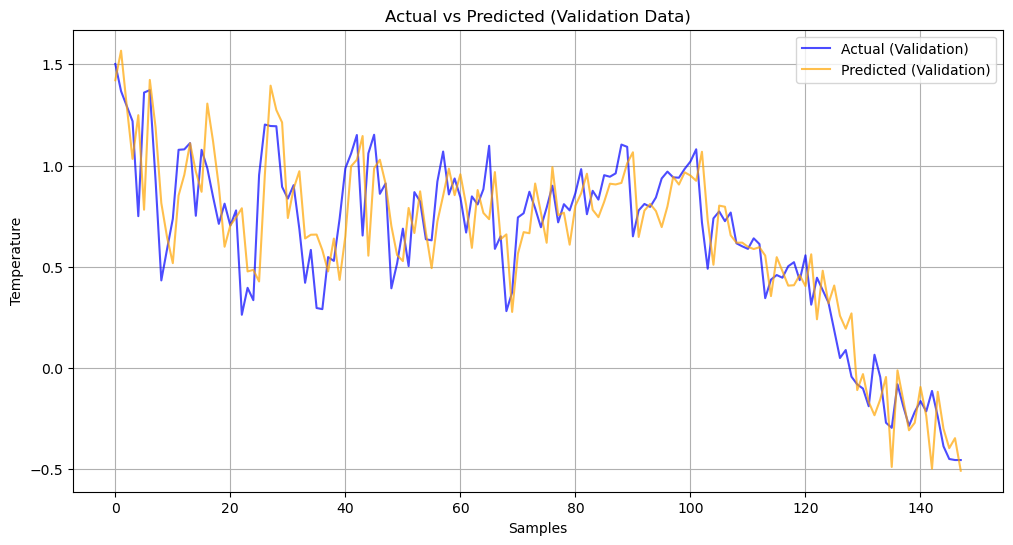

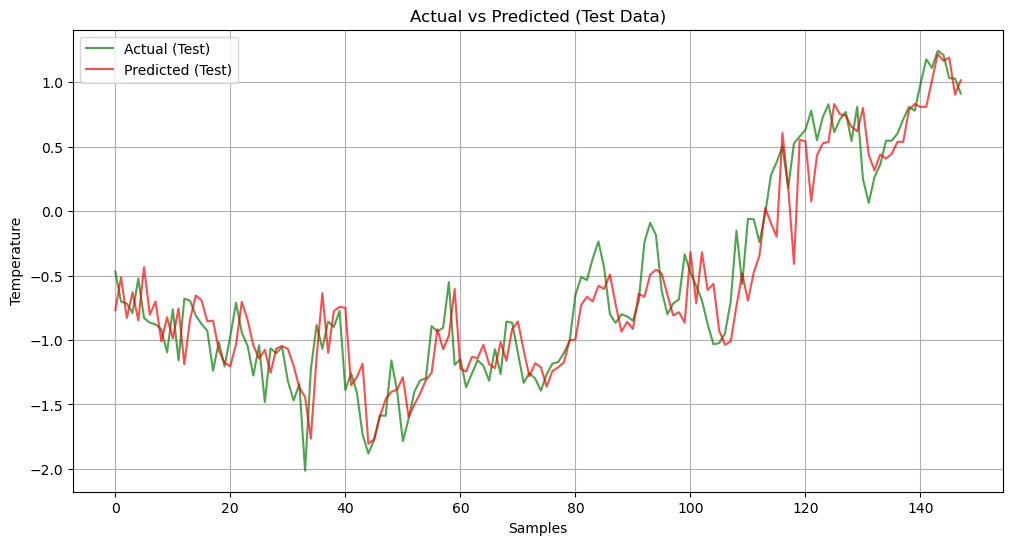

In [7]:
import matplotlib.pyplot as plt

# Plot for validation data
plt.figure(figsize=(12, 6))
plt.plot(y_validate, label="Actual (Validation)", color="blue", alpha=0.7)
plt.plot(y_val_pred, label="Predicted (Validation)", color="orange", alpha=0.7)
plt.title("Actual vs Predicted (Validation Data)")
plt.xlabel("Samples")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()

# Plot for test data
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual (Test)", color="green", alpha=0.7)
plt.plot(y_test_pred, label="Predicted (Test)", color="red", alpha=0.7)
plt.title("Actual vs Predicted (Test Data)")
plt.xlabel("Samples")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


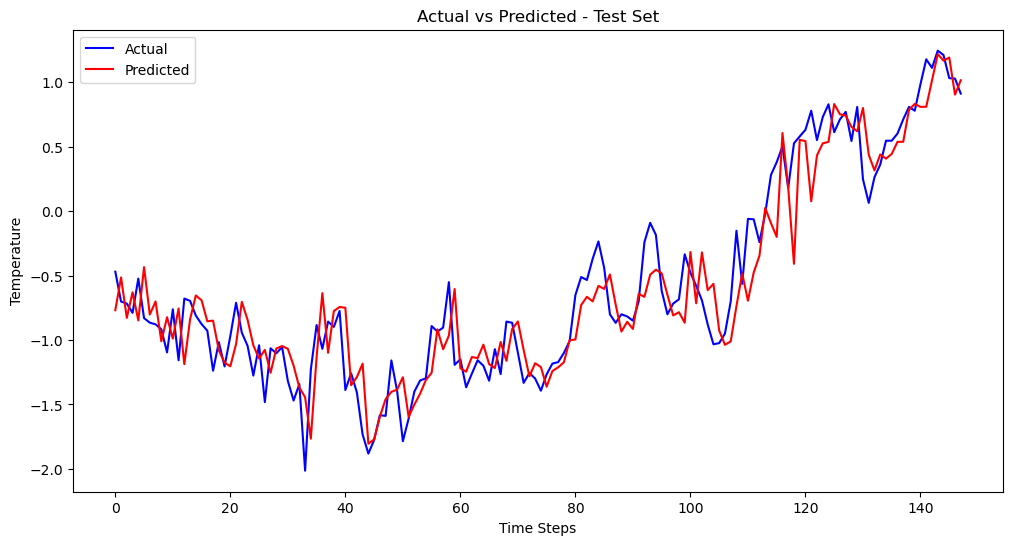

In [16]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for the test set
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_test_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted - Test Set')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()
